Based on https://www.kaggle.com/competitions/titanic

# Modules Import

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration

In [133]:
titanic_data = pd.read_csv('../datasets/titanic survival/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [134]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [135]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

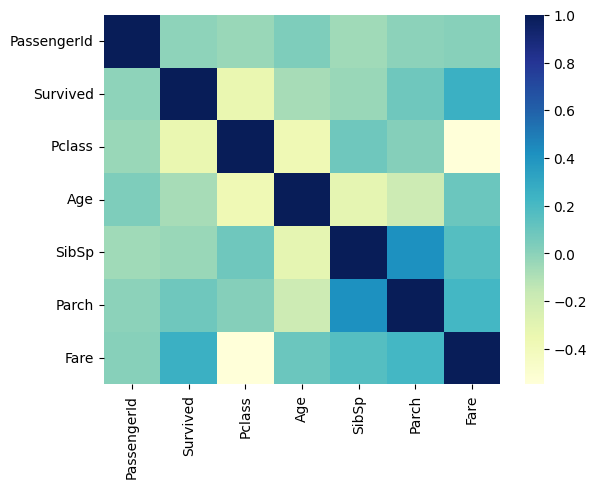

In [136]:
numeric_titanic_data = titanic_data.select_dtypes(include=['number'])
sns.heatmap(numeric_titanic_data.corr(), cmap="YlGnBu")

The focus is on the correlation between features and survival, specifically in the second column and across all rows (or conversely the second row across all columns).

# Preparing Data for Training and Testing

In [328]:
# Stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit

X = titanic_data.drop(columns=["Survived"]) # isolating features
y = titanic_data[["Survived"]] # isolating labels

# Instantiate StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # to make a train-test split using KFold split it is necessary to set n_splits to 1

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [345]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

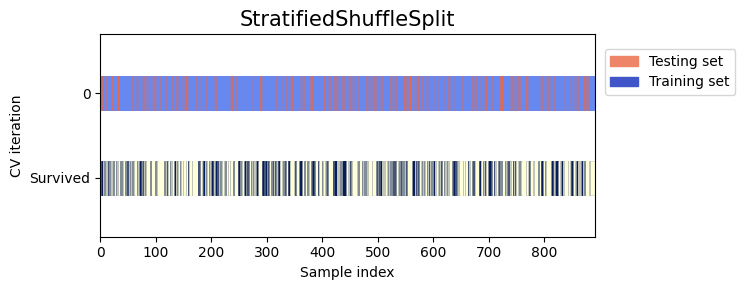

In [329]:
# Graphing the stratified shuffle split
from matplotlib.patches import Patch

# Define colormaps
cmap_data = plt.cm.YlGnBu
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=25):
    for ii, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[test_idx] = 1
        indices[train_idx] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices,
                    marker="_", lw=lw, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data)

    yticklabels = list(range(n_splits)) + ["Survived"]
    ax.set(yticks=np.arange(n_splits + 1) + 0.5, yticklabels=yticklabels, xlabel="Sample index",
            ylabel="CV iteration", ylim=[n_splits + 1.2, -0.2], xlim=[0, len(X)])
    ax.set_title(f"StratifiedShuffleSplit", fontsize=15)
    return ax

X = titanic_data.drop(columns=["Survived"]).values
y = titanic_data["Survived"].values

# Instantiate StratifiedShuffleSplit
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(sss, X, y, ax, n_splits=1)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.7),
)
plt.tight_layout()
fig.subplots_adjust(right=1)

plt.show()


Split the dataset into training and testing before applying one-hot encoding or imputing to prevent data leakage and ensure unbiased model evaluation.

In [330]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Define transformations
transformer = ColumnTransformer(transformers=[
    ('impute', SimpleImputer(strategy='mean'), ['Age']),
    ('onehot', OneHotEncoder(), ['Embarked', 'Sex'])
], remainder='passthrough') # keeps other columns unchanged

# Apply transformations
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

# Extract new columns names
cols = transformer.get_feature_names_out()
cols = [name.split('__', 1)[-1] for name in cols] # remove explanation on applied transformation

# Converting back to dataframes
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

In [331]:
X_test

,Age,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Sex_female,Sex_male,PassengerId,Pclass,Name,SibSp,Parch,Ticket,Fare,Cabin
0,24.0,0.0,0.0,1.0,0.0,0.0,1.0,566,3,"Davies, Mr. Alfred J",2,0,A/4 48871,24.15,NaN
1,44.0,0.0,0.0,1.0,0.0,0.0,1.0,161,3,"Cribb, Mr. John Hatfield",0,1,371362,16.1,NaN
2,22.0,1.0,0.0,0.0,0.0,0.0,1.0,554,3,"Leeni, Mr. Fahim (""Philip Zenni"")",0,0,2620,7.225,NaN
3,41.0,0.0,0.0,1.0,0.0,0.0,1.0,861,3,"Hansen, Mr. Claus Peter",2,0,350026,14.1083,NaN
4,29.807687,0.0,1.0,0.0,0.0,1.0,0.0,242,3,"Murphy, Miss. Katherine ""Kate""",1,0,367230,15.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,25.0,0.0,0.0,1.0,0.0,1.0,0.0,881,2,"Shelley, Mrs. William (Imanita Parrish Hall)",0,1,230433,26.0,NaN
175,20.0,0.0,0.0,1.0,0.0,0.0,1.0,92,3,"Andreasson, Mr. Paul Edvin",0,0,347466,7.8542,NaN
176,28.0,0.0,0.0,1.0,0.0,0.0,1.0,884,2,"Banfield, Mr. Frederick James",0,0,C.A./SOTON 34068,10.5,NaN
177,23.0,1.0,0.0,0.0,0.0,1.0,0.0,474,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",0,0,SC/AH Basle 541,13.7917,D


Decision was taken to drop name/id/ticket/cabin/embarked_nan features, i think cabin contains lots of information about passenger's position in the boat and thus chances are it has meaning but i don't know how to 
encode it so i am condemned to removing it ; (

In [332]:
columns = ['Embarked_nan', 'PassengerId', 'Name', 'Ticket', 'Cabin']
cols = [c for c in cols if c not in columns]

X_train = X_train.drop(columns, axis=1)
X_test = X_test.drop(columns, axis=1)

In [333]:
X_train.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass,SibSp,Parch,Fare
0,29.807687,0.0,0.0,1.0,0.0,1.0,3,0,0,56.4958
1,29.807687,0.0,0.0,1.0,0.0,1.0,2,0,0,0.0
2,29.807687,0.0,0.0,1.0,0.0,1.0,1,0,0,221.7792
3,18.0,0.0,0.0,1.0,1.0,0.0,3,0,1,9.35
4,31.0,0.0,0.0,1.0,1.0,0.0,2,1,1,26.25


In [334]:
X_test.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass,SibSp,Parch,Fare
0,24.0,0.0,0.0,1.0,0.0,1.0,3,2,0,24.15
1,44.0,0.0,0.0,1.0,0.0,1.0,3,0,1,16.1
2,22.0,1.0,0.0,0.0,0.0,1.0,3,0,0,7.225
3,41.0,0.0,0.0,1.0,0.0,1.0,3,2,0,14.1083
4,29.807687,0.0,1.0,0.0,1.0,0.0,3,1,0,15.5


In [335]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Age         712 non-null    object
 1   Embarked_C  712 non-null    object
 2   Embarked_Q  712 non-null    object
 3   Embarked_S  712 non-null    object
 4   Sex_female  712 non-null    object
 5   Sex_male    712 non-null    object
 6   Pclass      712 non-null    object
 7   SibSp       712 non-null    object
 8   Parch       712 non-null    object
 9   Fare        712 non-null    object
dtypes: object(10)
memory usage: 55.8+ KB


In [336]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Age         179 non-null    object
 1   Embarked_C  179 non-null    object
 2   Embarked_Q  179 non-null    object
 3   Embarked_S  179 non-null    object
 4   Sex_female  179 non-null    object
 5   Sex_male    179 non-null    object
 6   Pclass      179 non-null    object
 7   SibSp       179 non-null    object
 8   Parch       179 non-null    object
 9   Fare        179 non-null    object
dtypes: object(10)
memory usage: 14.1+ KB


In [337]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [338]:
X_train.head()

,Age,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass,SibSp,Parch,Fare
0,-1.365807e-15,-0.492527,-0.289333,0.616316,-0.742427,0.742427,0.829568,-0.465084,-0.466183,0.513812
1,-1.365807e-15,-0.492527,-0.289333,0.616316,-0.742427,0.742427,-0.370945,-0.465084,-0.466183,-0.662563
2,-1.365807e-15,-0.492527,-0.289333,0.616316,-0.742427,0.742427,-1.571457,-0.465084,-0.466183,3.955399
3,-9.078708e-01,-0.492527,-0.289333,0.616316,1.346933,-1.346933,0.829568,-0.465084,0.727782,-0.467874
4,9.167471e-02,-0.492527,-0.289333,0.616316,1.346933,-1.346933,-0.370945,0.478335,0.727782,-0.115977


# Training

In [339]:
# Testing various algorithms
from sklearn.model_selection import GridSearchCV

In [346]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
param_grid = [
    {"n_estimators":[10, 100, 200, 500],
     "max_depth":[None, 5, 10],
     "min_samples_split":[2, 3, 4]}
]

grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [347]:
best_classifier = grid_search.best_estimator_
best_classifier

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=200)

In [359]:
training_score = best_classifier.score(X_train, y_train)
testing_score = best_classifier.score(X_test, y_test)
print(f'Training score of {training_score:.2f} and testing score of {testing_score:.2f}')


Training score of 0.85 and testing score of 0.80


In [350]:
print(grid_search.best_params_)

{'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 200}


In [370]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()

param_grid = [
    {
        "penalty": ['l2'],
        "solver": ['lbfgs'],
        "fit_intercept": [False, True]},
]

grid_search = GridSearchCV(log_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'fit_intercept': [False, True], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
             return_train_score=True, scoring='accuracy')

In [371]:
best_classifier = grid_search.best_estimator_
training_score = best_classifier.score(X_train, y_train)
testing_score = best_classifier.score(X_test, y_test)
print(f'Training score of {training_score:.2f} and testing score of {testing_score:.2f}')


Training score of 0.81 and testing score of 0.79


Doing slightly worst than random forest.